In [4]:
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
import scipy.signal as signal
from scipy.interpolate import make_lsq_spline, BSpline
from scipy.interpolate import make_interp_spline
from scipy.interpolate import splrep

import test_data as td
# if td.DATA is None:
td.set_test_data(
data_size=20000, 
start_time=datetime.datetime(2023, 3, 21, 12, 24).timestamp(),
moving_av=True
    )


Test data size is 12835
Test data start time is 2023:01:03 21:48
Test data end time is   2023:01:16 20:19
Subtracting moving avarage: True


In [22]:
import core as co
import piecewise_fit as ls

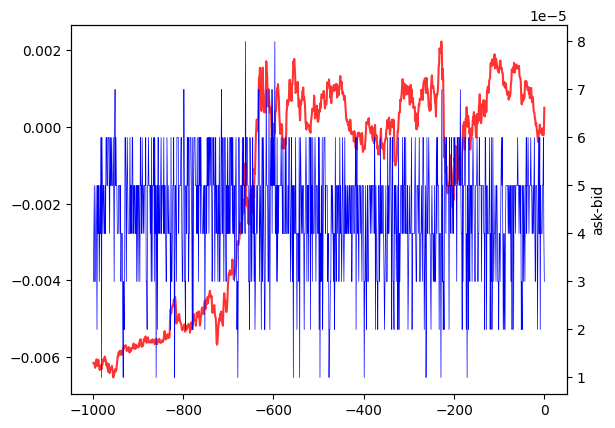

In [27]:
value_open = td.VALUE[200: 1200]
cndl_count = np.arange(len(value_open), dtype='float64')
cndl_count = cndl_count - cndl_count[-1]
ask = np.array([v[0] for v in value_open])
bid = np.array([v[1] for v in value_open])

fig, ave = plt.subplots()
ave.plot(cndl_count, (ask + bid) / 2, color='red', label='ask-bid', alpha=0.8)
div = ave.twinx()
div.plot(cndl_count, ask - bid, color='blue', linewidth='0.5')
div.set_ylabel('ask-bid')
plt.show()

savgol_filter = co.Savgol_filter(window=50, order=3)

np.set_printoptions(formatter={'float_kind':"{:-.3e}".format})

## Klasyfikacja prognozy

* Trzy rodzaje:
    * bid
    * ask
    * wait

* Atrybuty prognozy:
    * czas zasięgu
    * czynniki paniki - czas i poziom
    * poziom transakcji

Prognoza sugeruje transakcję natychmiast, gdy zostanie przekroczony 'poziom transakcji'. Prognoza obiecuje, że cena osiągnie ten poziom w okresie 'czasu zasięgu` prognozy. Jeśli zmiany ceny nie będą monotoniczne, odchylenia od monotoniczności nie będą większe niż określone przez 'czynniki paniki'.


In [ ]:


class Forecast:
    def __init__(self, value):
        self.value = value
        self.begin = value[0]
        self.end = value[-1]
        self.min = min(value)

2.6e-06
3.8e-06


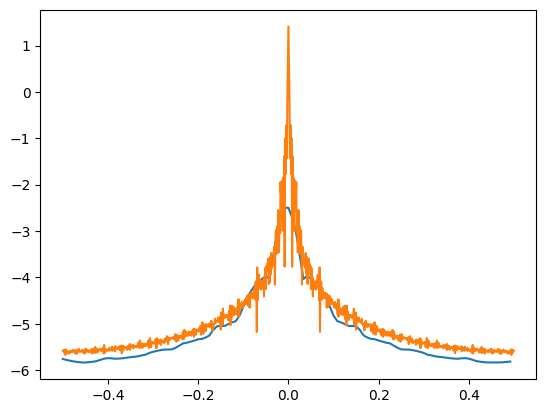

In [44]:
def power_spectrum(values, freq=0, filter=False):
    if values is None:
        return None, None, None
    ps = np.abs(np.fft.fft(values))**2
    freqs = np.fft.fftfreq(len(values), d=1)
    idx = np.argsort(freqs)
    freqencies = freqs[idx]
    log_powers = [math.log10(p) for p in ps[idx]] 
    log_powers_filtered = signal.savgol_filter(log_powers, 10, 2)
    for i in range(len(freqencies)):
        if freqencies[i] > - math.fabs(freq):
            log_power = log_powers_filtered[i]
            break

    if filter:
        log_powers = log_powers_filtered
    return freqencies, log_powers, 10 ** log_power

%matplotlib inline
fig = plt.figure()
freqencies, log_powers, power = power_spectrum(value, freq=0.3, filter=True)
if freqencies is not None:
    print(f'{power:1.1e}')
    plt.plot(freqencies, log_powers, label='values')

freqencies, log_powers, power = power_spectrum(filtered_savgol, freq=0.3, filter=False)
if freqencies is not None:
    print(f'{power:1.1e}')
    plt.plot(freqencies, log_powers, label='filtered')

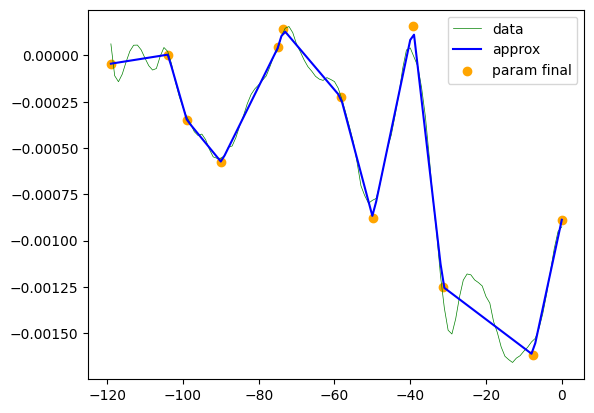

In [36]:
NUMDER_PIECES = 10
WINDOW = 120
K = 1
SCALE_X = 1.e-6

def piecewise(
        shift=0, window=WINDOW, filter=co.Savgol_filter(window=15, order=5),
        scale_x=SCALE_X, number_pieces=NUMDER_PIECES, k=K):
    value = td.VALUE[shift: window + shift]
    if filter is not None:
        value = filter.filter(value)
    cndl_count = np.arange(-len(value) + 1, 1)
    piecewise = ls.Fitter(ls.Splines(
        x=cndl_count, y=value, scale_x=scale_x, number_pieces=number_pieces, k=k) )
    piecewise.run()
    return piecewise.func_class, cndl_count, value

clazz, cndl_count, value = piecewise(shift=0, number_pieces=NUMDER_PIECES, k=1)

%matplotlib inline
fig = plt.figure()

plt.plot(cndl_count, value, color='green', label='data', linewidth='0.5')
plt.plot(cndl_count, clazz.approx(cndl_count), color='blue', label='approx')
plt.scatter(*clazz.knots(), color='orange', label='param final')

plt.legend()
plt.show()

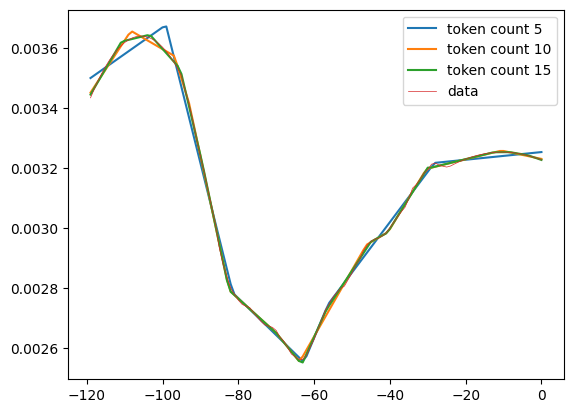

In [20]:
%matplotlib inline
fig = plt.figure()

for n in [5, 10, 15]:
    clazz, cndl_count, value = piecewise(number_pieces=n, shift=2000)
    # accuracy = clazz.accuracy()
    # print(f'token count: {n:3d}; relative accuracy: {accuracy:.2e}')
    plt.plot(cndl_count, clazz.approx(cndl_count), label=f'token count {n}')

plt.plot(cndl_count, value, label='data', linewidth='0.5')
plt.legend()
plt.show()

## Czy tokenizacja jest stabilna.

Ustalamy doświadczalnie okres czasu przeszłego stanowiący context decyzji: tokeny z tego okresu zasilają procesor. Nie chcemy żeby ten ciąg tokenów zmieniał się nie tylko przez przesunięcie końców a ewoluował wewnętrz tego okresu obserwacji.

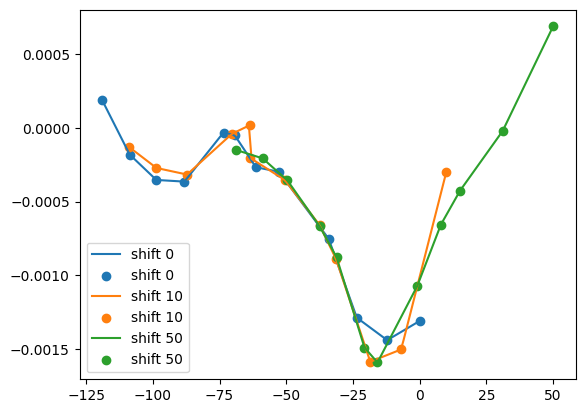

In [21]:
%matplotlib inline
fig = plt.figure()

for shift in [0, 10, 50]:
    clazz, cndl_count, value = piecewise(shift=shift)
    plt.plot(cndl_count+shift, clazz.approx(cndl_count), label=f'shift {shift}')
    plt.scatter(clazz.knots()[0]+shift, clazz.knots()[1], label=f'shift {shift}')
plt.legend()
plt.show()

In [38]:
def image3d(clazz):
    xk = clazz.knots()[0] - clazz.knots()[-1]
    yk = clazz.knots()[1]    
    knots = []
    prev = {'x': xk[0], 'y': yk[0]}
    for i in range(1, len(xk)):
        next = {'x': xk[i], 'y': yk[i]}
        knot = [prev, next]
        knots.append(knot)
        prev = next

    p3d = []
    for i in range(len(knots)):
        offset = knots[i][0]['x']
        p3d.append(np.array([knots[i][0]['y'], knots[i][1]['y'], knots[i][1]['x'] - offset]))

    return np.column_stack(p3d), p3d[-1]

sto = []
for shift in [0, 100, 200, 300, 400, 1000, 1100]:
    clazz, cndl_count, value = piecewise(shift=shift)
    sto.append((clazz, cndl_count, value, shift))

%matplotlib widget
fig = plt.figure(
    num='Chains of Tokens', 
    clear=True, figsize=(5, 5), frameon=False, layout='tight')

ax = plt.axes(projection='3d')
for clazz, cndl_count, value, shift in sto:
    xyz, curr = image3d(clazz)
    ax.plot3D (*xyz, label=f'shift {shift}')
    ax.scatter3D (*curr)

plt.axis('on')
# plt.axis([-0.005, 0.005, -0.005, 0.005, -0.005, 0.005])
plt.legend()
plt.show() 


DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.

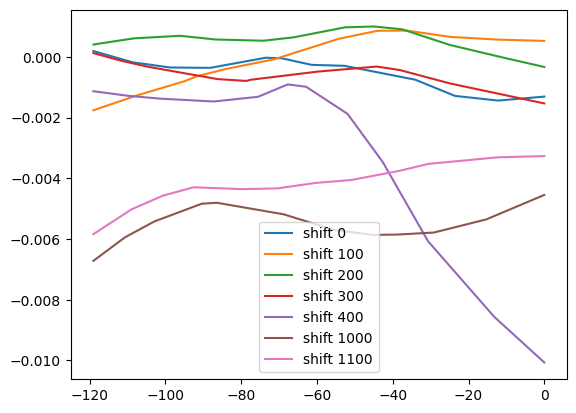

In [24]:
%matplotlib inline
fig = plt.figure(num='Piecewise Linear Approximation')

for clazz, cndl_count, value, shift in sto:
    xk = (clazz.knots()[0] - clazz.knots()[0][-1])
    yk = clazz.knots()[1]   
    knots = []
    prev = [xk[0], yk[0]]
    for i in range(1, len(xk)):
        next = [xk[i], yk[i]]
        knot = [prev, next]
        knots.append(knot)
        prev = next
        
    plt.plot(xk, yk, label=f'shift {shift}')
    
plt.axis('on')
plt.legend()
plt.show()

In [25]:

# hist_data = [values[1][0] for values in all_data]

# %matplotlib inline

# fig = plt.figure()
# plt.hist(hist_data, bins=100, edgecolor='black', density=True)
# plt.show()

# fig = plt.figure()
# sin_data = [math.sin(math.pi * n * 0.01) for n in range(5000)]
# plt.hist(sin_data, bins=100, edgecolor='black', density=True)
# plt.show()